In [356]:
from typing import Union, Any, Tuple
from collections.abc import Callable

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [357]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()
len(words)

32033

# Preprocess the data

In [358]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [359]:
import torch

# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 8
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [360]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '->', itos[y.item()])

........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o
.....dio -> n
....dion -> d
...diond -> r
..diondr -> e
.diondre -> .
........ -> x
.......x -> a
......xa -> v
.....xav -> i
....xavi -> e


# Model

In [361]:
class Linear:
    """A linear layer."""

    def __init__(
        self,
        fan_in: int,
        fan_out: int,
        bias: bool = False,
        generator: Union[torch.Generator, None] = None,
        activation: str = 'leaky_relu'
    ) -> None:
        """Initialize Linear."""
        self.weight = torch.randn((fan_in, fan_out), generator=generator)  #.abs()
        self.weight = torch.nn.init.kaiming_normal_(self.weight, nonlinearity=activation)
        self.bias = torch.randn(fan_out, generator=g) * 0.01 if bias else None
        self.out: Union[torch.tensor, None] = None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass"""
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

    def __str__(self) -> str:
        return self.__class__.__name__


class BatchNorm1d:
    """A batch normalization layer."""

    def __init__(self, dim: int, eps: float = 1e-5, momentum=0.001) -> None:
        """Initialize BatchNorm1d."""
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters, trained with backprop
        self.bngain = torch.ones((1, dim))  # gamma
        self.bnbias = torch.zeros((1, dim))  # beta
        # Buffers, trained with a running momentum update
        self.running_mean = torch.zeros((1, dim))
        self.running_std = torch.ones((1, dim))
        self.out: Union[torch.tensor, None] = None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        if self.training:
            if x.ndim == 2:
                dim = 0
            else:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xstd = x.std(dim, keepdim=True)

            # Update buffers
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_std = (1-self.momentum) * self.running_std + self.momentum * xstd
        else:
            xmean = self.running_mean
            xstd = self.running_std

        # Preserve last value for statistics. TODO: We're not doing sqrt(xvar + eps) here. Fix?
        self.out = self.bngain * (x - xmean) / (xstd + self.eps) + self.bnbias
        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]

    def __str__(self) -> str:
        return self.__class__.__name__


class Nonlinearity:
    """Nonlinearity."""

    def __init__(self, activation: str = 'leaky_relu') -> None:
        """Initialize Nonlinearity."""
        if activation == 'leaky_relu':
            self.act = torch.nn.LeakyReLU() 
        elif activation == 'relu':
            self.act = torch.nn.ReLU()
        elif activation == 'tanh':
            self.act = torch.nn.Tanh()
        else:
            raise ValueError(f"Unknown activation {activation}")
        self.activation = activation
        self.out: Union[torch.tensor, None] = None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass"""
        self.out = self.act(x)
        return self.out

    def __str__(self) -> str:
        return f"{self.__class__.__name__}:{self.activation}"

    def parameters(self):
        return []
    
class Embedding:
    """An embedding lookup."""

    def __init__(self, num_embeddings: int, embedding_dim: int, generator: torch.Generator = None) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim), generator=g)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    """Flattens n consecutive elements."""

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    """A container of layers invoked sequentially."""

    def __init__(self, layers: list[Callable[[torch.Tensor], torch.Tensor]]) -> None:
        self.layers = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    @property
    def shape(self) -> list[str]:
        """Return the shape of the model."""
        results = []
        for layer in self.layers:
            results.append(f"{layer.__class__.__name__}: {layer.out.shape}")
        return results



In [362]:
EMBED_SZ = 10
HIDDEN_LAYER_SZ = 100
CHAR_GRP = 2

class Model:

    def __init__(self, vocab_size: int, generator: torch.Generator = None, activation: str = 'leaky_relu') -> None:
        self.layers = Sequential([        
            Embedding(vocab_size, EMBED_SZ, generator=g),

            # Flattens in CONTEXT_SZ but instead want to group by 2s
            FlattenConsecutive(CHAR_GRP),
            Linear(EMBED_SZ * CHAR_GRP, HIDDEN_LAYER_SZ, activation=activation, generator=g, bias=False),
            BatchNorm1d(HIDDEN_LAYER_SZ),
            Nonlinearity(activation=activation),

            FlattenConsecutive(CHAR_GRP),
            Linear(HIDDEN_LAYER_SZ * CHAR_GRP, HIDDEN_LAYER_SZ, activation=activation, generator=g, bias=False),
            BatchNorm1d(HIDDEN_LAYER_SZ),
            Nonlinearity(activation=activation),

            FlattenConsecutive(CHAR_GRP),
            Linear(HIDDEN_LAYER_SZ * CHAR_GRP, HIDDEN_LAYER_SZ, activation=activation, generator=g, bias=False),
            BatchNorm1d(HIDDEN_LAYER_SZ),
            Nonlinearity(activation=activation),

            Linear(HIDDEN_LAYER_SZ, vocab_size, activation=activation, generator=g, bias=False),
        ])

        for layer in self.layers.layers:
            layer.training = True

        # Reset parameters for training
        for p in self.parameters():
            p.requires_grad = True

    def parameters(self):
        return self.layers.parameters()

    @property
    def num_parameters(self) -> int:
        """Total number of parameters."""
        return sum(p.nelement() for p in self.parameters())

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        return self.layers(x)
    
    @property
    def shape(self) -> list[str]:
        """Return the shape of the model."""
        return self.layers.shape
    


In [363]:
from statistics import mean
from tqdm.notebook import tqdm
from torch import nn
from torch.nn import functional as F

MINI_BATCH_SZ = 32

# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.cat([-1 * torch.ones(10000), torch.linspace(-1, -5, steps=5000)])
lrs = 10**lre
#plt.plot(range(0, len(lrs)), lrs)

lri = []
lossi = []
loglossi = []
loglossiavg = []
stepi = []
ud = []

activation = 'leaky_relu'
g = torch.Generator().manual_seed(42)
model = Model(vocab_size, generator=g, activation=activation)
print(model.num_parameters)

with torch.enable_grad():
    pbar = tqdm(range(len(lrs)))
    for i in pbar:
        # Mini batch
        ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,), generator=g) # (MINI_BATCH_SZ)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # Forward pass
        logits = model.forward_pass(Xb)
        loss = F.cross_entropy(logits, Yb)
        
        # Update parameters
        lr = lrs[i]
        sgd = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)
        sgd.zero_grad()
        loss.backward()
        sgd.step()

        # Track stats
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())
        if i < 500:
            loglossiavg.append(loss.log10().item())
        else:
            loglossiavg.append(mean(loglossi[-100:]))
        if i % 1000 == 0:
            pbar.set_description("LR: %0.4f Loss %0.4f" % (lr, mean(lossi[-500:])))
            with torch.no_grad():
                ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in model.parameters()])
        #if i >= 10000:
        #    break


45570


  0%|          | 0/15000 [00:00<?, ?it/s]

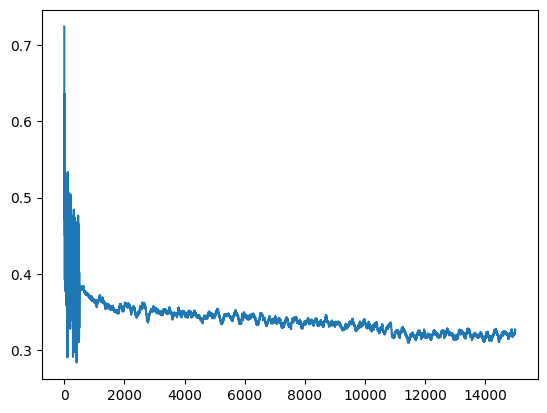

In [364]:
plt.plot(loglossiavg)

# View Training Results

In [365]:
print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
    'num_parameters': sum(p.nelement() for p in model.parameters()),
})

for l in model.layers.layers:
    l.training = False

with torch.no_grad():
    xtr_loss = F.cross_entropy(model.forward_pass(Xtr), Ytr)
    print(f"Xtr loss: {xtr_loss:0.4f}")

    xdev_loss = F.cross_entropy(model.forward_pass(Xdev), Ydev)
    print(f"Xdev loss: {xdev_loss:0.4f}")

{'MINI_BATCH_SZ': 32, 'CONTEXT_SZ': 8, 'EMBED_SZ': 10, 'HIDDEN_LAYER_SZ': 100, 'num_parameters': 45570}
Xtr loss: 2.0814
Xdev loss: 2.1032


# Sample

In [366]:

for l in model.layers.layers:
    l.training = False

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        x = torch.tensor([context])
        logits = model.forward_pass(x)

        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)

        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
             break
    print(''.join(out))

vennadi.
elieigh.
keniel.
raavia.
illle.
haxdiyanna.
zyleigh.
brizye.
emyne.
dorllyna.
kaida.
cannon.
gilto.
qui.
doersone.
koystya.
elman.
kaylyn.
shaphon.
hayeliah.


In [367]:
ix = torch.randint(0, Xtr.shape[0], (4,), generator=g) # (MINI_BATCH_SZ)
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model.forward_pass(Xb)
print(Xb.shape)
Xb


torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 19, 21, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0,  0, 13,  5, 18,  9],
        [ 0,  0,  0, 11, 18,  1, 25, 20]])

In [368]:
# Layer inspection

for s in model.layers.shape:
    print(s)

Embedding: torch.Size([4, 8, 10])
FlattenConsecutive: torch.Size([4, 4, 20])
Linear: torch.Size([4, 4, 100])
BatchNorm1d: torch.Size([4, 4, 100])
Nonlinearity: torch.Size([4, 4, 100])
FlattenConsecutive: torch.Size([4, 2, 200])
Linear: torch.Size([4, 2, 100])
BatchNorm1d: torch.Size([4, 2, 100])
Nonlinearity: torch.Size([4, 2, 100])
FlattenConsecutive: torch.Size([4, 200])
Linear: torch.Size([4, 100])
BatchNorm1d: torch.Size([4, 100])
Nonlinearity: torch.Size([4, 100])
Linear: torch.Size([4, 27])


# Performance log

## Larger context size

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 8, 'EMBED_SZ': 10, 'HIDDEN_LAYER_SZ': 200, 'num_parameters': 183724}
Xtr loss: 1.8502
Xdev loss: 1.9980
```

## Flat to Hierarchical / WaveNet first attempt

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 8, 'EMBED_SZ': 10, 'HIDDEN_LAYER_SZ': 200, 'num_parameters': 170870}
Xtr loss: 1.9189
Xdev loss: 2.0017
```